# Analysis of growth, size and time correlations

This notebook does the analysis presented in section 1 of the paper, which concerns the relative contributions of growth rate and generation time variation to size control. 

# Setup

In [1]:
using CSV, DataFrames, Distributions,StatsBase, PythonPlot, LinearAlgebra
using Turing

## Load simulated data

In [12]:
sim_dir = "./../output/sims/"
files = readdir(sim_dir)
τ_range = [parse(Int,split(split(split(f,"_")[end],"-")[1],"=")[end]) for f in files];

In [13]:


sims_raw = []
sims_cells = []
for f in files
    df = CSV.read(sim_dir*"/"*f,DataFrame)
    push!(sims_raw,df)
    df_cells = combine(groupby(df,[:position]),:λ=>mean=>:gr,:M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,:time=>(x->x[end]-x[1])=>:gt)
    df_cells[:,:x] = log.(df_cells.M0 ./ mean(df_cells.M0))
    df_cells[:,:γ] = log.(df_cells.Mf ./ df_cells.M0)
    df_cells[:,:φ] = df_cells.gt .* df_cells.gt
    push!(sims_cells,df_cells[df_cells.gt .> 0,:])
end
#U  = [(u .- mean(u,dims=1)) ./ std(u,dims=1) for u in U]

## Load experimental data

In [14]:
NSF_CAREER_PATH = "/Users/elevien/Dartmouth College Dropbox/Ethan Levien/PROPOSALS/NSFCareer2024/figures/growth_dynamics"

df_all = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
lineages = unique(df_all.lineage);

function get_gr(time,lnM)
    age = time .- time[1]
    X = hcat(ones(length(age)),age)
    b = X \ lnM
    return b[2]
end


df_all_cells = combine(groupby(df_all,[:lineage,:position]),[:time,:lnM]=>get_gr=>:gr,
:M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,:time=>(x->x[end]-x[1])=>:gt)


for df in groupby(df_all_cells,:lineage)
    df[:,:x] = log.(df.M0 ./ mean(df.M0))
    df[:,:γ] = log.(df.Mf ./ df.M0)
    df[:,:φ] = df.gt .* df.gt
end

# Basic comparisons to data

## Visual comparison of mass, growth and time traces

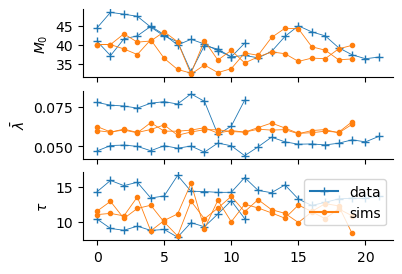

In [15]:
fig, axs = subplots(figsize=(4,3),nrows=3,sharex=true)
lw = 0.6
ax = axs[0]
for df in groupby(df_all_cells,:lineage)[3:4]
    ax.plot(df.M0,"C0-+",lw= lw)
end

for df in sims_cells[1:2]
    ax.plot(df.M0[1:20],"C1.-",lw= lw)
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_ylabel(L"$M_0$")

ax = axs[1]
for df in groupby(df_all_cells,:lineage)[3:4]
    ax.plot(df.gr,"C0-+",lw= lw)
end

for df in sims_cells[1:2]
    ax.plot(df.gr[1:20],"C1.-",lw= lw)
end
ax.set_ylabel(L"$\bar{\lambda}$")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)

ax = axs[2]
for df in groupby(df_all_cells,:lineage)[3:4]
    ax.plot(df.gt,"C0+-",lw= lw)
end
ax.set_ylabel(L"$\tau$")

for df in sims_cells[1:2]
    ax.plot(df.gt[1:20],"C1.-",lw= lw)
end

ax.plot([],[],"C0+-",label="data")
ax.plot([],[],"C1.-",label="sims")

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.legend()
fig

# Conditional cell-size control analysis

In [16]:

function alpha_decomp(x,y,z) 
    -cov(x,y)/var(y) * mean(z) 
end

alphas_tau = []
alphas_gr= []
alphas = []


for df in groupby(df_all_cells,:lineage)
    push!(alphas_tau,alpha_decomp(df.gt,df.x,df.gr))
    push!(alphas_gr,alpha_decomp(df.gr,df.x,df.gt))
    push!(alphas,alpha_decomp(df.γ,df.x,ones(length(df.gt))))
end

 # approach used in Cadart et al. when they don't have access to growth rate
alphas_tau_c = alphas .- alphas_gr


alphas_tau_sims = []
alphas_gr_sims= []
alphas_sims = []

for df in sims_cells
    df = df[1:20,:]
    push!(alphas_tau_sims,alpha_decomp(df.gt,df.x,df.gr))
    push!(alphas_gr_sims,alpha_decomp(df.gr,df.x,df.gt))
    push!(alphas_sims,alpha_decomp(df.γ,df.x,ones(length(df.gt))))
end



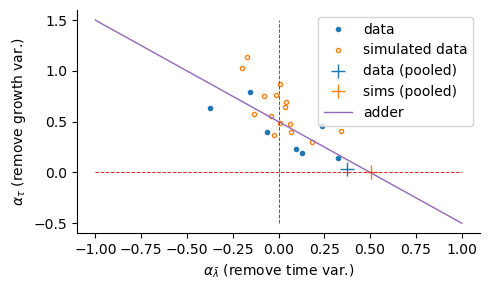

In [17]:
fig, ax = subplots(figsize=(5,3))


# --------------------------------------
# plot alphas for data
ax.plot(alphas_gr,alphas_tau,".",label="data")
ax.plot(alphas_gr_sims,alphas_tau_sims,".",label="simulated data",fillstyle="none")

# and pooled
ax.plot(alpha_decomp(df_all_cells.gt,df_all_cells.x,df_all_cells.gr)
,alpha_decomp(df_all_cells.gr,df_all_cells.x,df_all_cells.gt),"C0+",markersize=10,label="data (pooled)")

# --------------------------------------
sims_pooled = vcat(sims_cells...)
ax.plot(alpha_decomp(sims_pooled.gt,sims_pooled.x,sims_pooled.gr)
,alpha_decomp(sims_pooled.gr,sims_pooled.x,sims_pooled.gt),"C1+",markersize=10,label="sims (pooled)")

# --------------------------------------
# plot some guidelines
xrng = collect(-1:0.1:1)
ax.plot(xrng,1/2 .- xrng,"C4-",label="adder",lw=1)
ax.vlines([0],-1/2,1+1/2,linestyle="--",lw=0.7,color="C3")
ax.plot(xrng,zeros(length(xrng)),linestyle="--",lw=0.7,color="C3")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.legend(frameon=true)
ax.set_xlabel(L"$\alpha_{\bar{\lambda}}$ (remove time var.)")
ax.set_ylabel(L"$\alpha_{\tau}$ (remove growth var.)")

for df in sims_cells
    ax.plot()
end

tight_layout()
fig



# Simpson's paradox

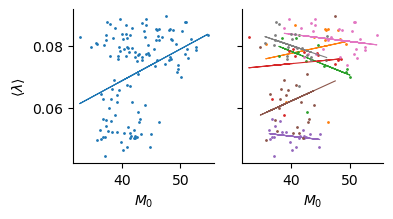

In [18]:

fig, (ax1,ax)= subplots(figsize=(4,2),ncols=2,sharex=true,sharey=true)



ax1.plot(df_all_cells.M0,df_all_cells.gr,".",markersize=2)
df = df_all_cells
X = hcat(ones(length(df.M0)),df.M0)
b = X\df.gr
xrange = min(df.M0...):0.1:max(df.M0...)
ax1.plot(X[:,2],X*b,color="C0",lw=0.8)


ax.set_xlabel(L"$M_0$")

ax1.set_ylabel(L"$\langle \lambda \rangle$")
ax1.spines["right"].set_visible(false)
ax1.spines["top"].set_visible(false)
#ax1.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)
ax1.set_xlabel(L"$M_0$")


dfs = groupby(df_all_cells,:lineage)
for i in 1:length(dfs)
    df = dfs[i]
    ax.plot(df.M0,df.gr,".",color="C"*string(i),markersize=2)
    X = hcat(ones(length(df.M0)),df.M0)
    b = X\df.gr
    xrange = min(df.M0...):0.1:max(df.M0...)
    ax.plot(X[:,2],X*b,color="C"*string(i),lw=0.8)

end


ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
#gca().tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)


#savefig(NSF_CAREER_PATH*"/simpsons.pdf",bbox_inches="tight")

fig

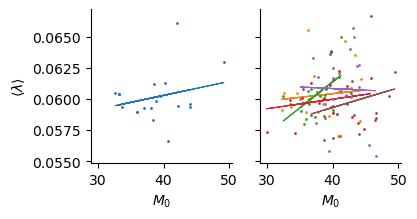

In [19]:

fig, (ax1,ax)= subplots(figsize=(4,2),ncols=2,sharex=true,sharey=true)


sims_pooled = vcat(sims_cells...)
sims_pooled = sims_pooled[rand(1:100,20),:]
ax1.plot(sims_pooled.M0,sims_pooled.gr,".",markersize=2)
X = hcat(ones(length(sims_pooled.M0)),sims_pooled.M0)
b = X\sims_pooled.gr
xrange = min(df.M0...):0.1:max(df.M0...)
ax1.plot(X[:,2],X*b,color="C0",lw=0.8)


ax.set_xlabel(L"$M_0$")

ax1.set_ylabel(L"$\langle \lambda \rangle$")
ax1.spines["right"].set_visible(false)
ax1.spines["top"].set_visible(false)
#ax1.tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)
ax1.set_xlabel(L"$M_0$")


for i in 1:5
    df = sims_cells[i][1:20,:]
    ax.plot(df.M0,df.gr,".",color="C"*string(i),markersize=2)
    X = hcat(ones(length(df.M0)),df.M0)
    b = X\df.gr
    xrange = min(df.M0...):0.1:max(df.M0...)
    ax.plot(X[:,2],X*b,color="C"*string(i),lw=0.8)

end


ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
#gca().tick_params(axis="both", left=false, top=false, right=false, bottom=false, labelleft=false, labeltop=false, labelright=false, labelbottom=false)


#savefig(NSF_CAREER_PATH*"/simpsons.pdf",bbox_inches="tight")
fig